In [1]:
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt
import random

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.0


In [3]:
with open('../input/smart-reply-data-preprocessing/tokenizer.pickle', 'rb') as fp:
    tokenizer = pickle.load(fp)
    
with open('../input/smart-reply-data-preprocessing/input_sequence.pickle', 'rb') as fp:
    input_sequences = pickle.load(fp)

In [4]:
total_words = len(tokenizer.word_index) + 1

In [5]:
for inp_sequence in input_sequences[:50]:
    sentence = ""
    for predicted in inp_sequence:
        output_word = None
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            if word == 'eos':
                break

            output_word = word
            #print(predicted, output_word)
            break
    if output_word:
        sentence = sentence + " " + output_word
    #print(sentence)

In [6]:
import numpy as np

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    #label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(input_sequences)

In [7]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = tf.keras.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 100, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    #model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(256))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam())
    
    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 154, 100)          19168200  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 191682)            49262274  
Total params: 68,796,042
Trainable params: 68,796,042
Non-trainable params: 0
_________________________________________________________________


In [8]:
len(predictors)

3260475

In [9]:
# using partial data to avoid notebook crashing
k = 1.0

k_predictors = predictors[:int(len(predictors) * k)]
k_label = label[:int(len(label) * k)]
print(len(k_predictors))

3260475


In [10]:
history = model.fit(k_predictors, k_label, validation_split=0.33, epochs=3, verbose=1)

Epoch 1/3
68267/68267 [==============================] - 2391s 35ms/step - loss: 5.7662 - val_loss: 5.2523
Epoch 2/3
68267/68267 [==============================] - 2359s 35ms/step - loss: 5.0612 - val_loss: 5.2176
Epoch 3/3
68267/68267 [==============================] - 2361s 35ms/step - loss: 4.9371 - val_loss: 5.2203


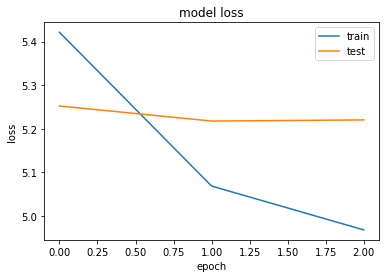

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
model.save('ubuntu_ds_model_1.hdf5')

In [13]:
from tensorflow import keras
model = keras.models.load_model('ubuntu_ds_model_1.hdf5')

In [14]:
def generate_greedy_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                if word == 'eos':
                    break
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [15]:
def get_next_word_dist(possible_seed_texts, max_sequence_len):
    possible_predictions = []
    for seed_text in possible_seed_texts:
        #print("Seed text - ", seed_text)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)[0]
        #print("Predicted - ", predicted[34])
        possible_predictions.append(predicted)
    
    #print(possible_predictions)
    return possible_predictions

In [16]:
eos_token = tokenizer.texts_to_sequences(['eos'])[0]
print(eos_token)

[1]


In [17]:
from math import log
def generate_beam_text(seed_text, next_words, model, max_sequence_len, beam_search_n, break_at_eos):
    sequences = [[list(), 0.0]]
    possible_seed_texts = [[seed_text]]
    for _ in range(next_words):
        
        # get word probability distribution
        predicted_distributions = get_next_word_dist(possible_seed_texts, max_sequence_len)
        #print("Len - predicted_distributions ", len(predicted_distributions))
        
        all_candidates = list()
        for i in range(len(sequences)):
            #print("Len", "predicted_distributions", str(len(predicted_distributions[0])))
            for j in range(len(predicted_distributions[i])):
                seq, score = sequences[i]
                
                if predicted_distributions[i][j] > 0:
                    candidate = [seq + [j], score - log(predicted_distributions[i][j])]
                    if break_at_eos and j == eos_token:
                        continue
                    else:
                        all_candidates.append(candidate)

        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        
        sequences = ordered[:beam_search_n]
        
        # clear list and put top beam results
        possible_seed_texts = list()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            sentence = seed_text
            for predicted in seq:
                output_word = None
                for word, index in tokenizer.word_index.items():
                    if index == predicted:
                        if word == 'eos' and break_at_eos:
                            break
                        
                        output_word = word
                        #print(predicted, output_word)
                        break
                if output_word:
                    sentence = sentence + " " + output_word
            
            possible_seed_texts.append(sentence)

            to_print = ' '.join(sentence.replace('eos', '').split())
            print(to_print.replace(seed_text, "", 1), score)
          
          
        print("-----")
    #return seed_text.title()

In [18]:
print(generate_greedy_text("hello", 100, model, max_sequence_len))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Hello                                                                                                    


In [19]:
print(generate_beam_text("sorry", 10, model, max_sequence_len, 25, False))

 0.8508937592680019
 i 3.060561389685263
 wrong 4.179369480902995
 for 4.529840003845657
 that 4.5414567602057865
 about 4.596415283103745
 is 4.697596110524438
 but 4.799114262918541
 the 4.806963446207597
 im 5.0675685563595545
 its 5.113564746942258
 just 5.1719605976608305
 it 5.182140103642143
 to 5.219649986443153
 you 5.307590214682779
 not 5.338209878290732
 no 5.406928759325598
 p 5.419948359925696
 was 5.462558040197929
 if 5.47268997034397
 and 5.5123708094426105
 in 5.561406932332575
 didnt 5.572448069957885
 a 5.577123357477363
 what 5.60068771830921
-----
 i 3.6243092415795353
 please 3.8899411700727176
 you 3.936289461202358
 no 4.612288204984388
 what 4.743552192776505
 yes 4.926030877276325
 thanks 4.943841702407189
 the 4.981320725270514
 sorry 4.995802521652944
 its 5.010143418769223
 try 5.0887617748374065
 it 5.176113793825214
 just 5.256168509162785
 i dont 5.275705607394167
 5.296848749705713
 hi 5.301103976715108
 sudo 5.329947610247713
 thats 5.370063889504475


In [20]:
print(generate_beam_text("good morning", 10, model, max_sequence_len, 25, False))

 1.3935241912338105
 is 3.7974517293223924
 to 3.876545951488216
 it 4.3427579747451945
 that 4.53586058832893
 and 4.601979563510975
 i 4.717905593673366
 the 4.801231840314374
 or 5.0090656638925966
 but 5.108001547329442
 do 5.328458313297793
 you 5.4882697393321225
 thanks 5.60417081139447
 for 5.643855109076257
 this 5.644924180942466
 in 5.691313777577177
 with 5.898599711259292
 on 6.021725670648308
 sudo 6.042427063764779
 a 6.053157878541428
 just 6.105485929234719
 its 6.129953366450226
 though 6.15022280957378
 use 6.171728680207656
 d 6.1943826172674195
-----
 i 4.160078780686255
 you 4.542242500117403
 no 4.941835403644541
 please 5.115576901362356
 thanks 5.299344423061539
 yes 5.441796415048401
 lol 5.5407424002282175
 its 5.567097945646542
 try 5.593586237981878
 it 5.673444080967765
 5.679013278433345
 the 5.740829100576997
 what 5.753804920803938
 yeah 5.780324748191087
 thanks 5.807122646548059
 sorry 5.864939165334648
 just 5.865173589158103
 thats 5.867685214757328

In [21]:
print(generate_beam_text("hello", 10, model, max_sequence_len, 15, False))

 0.1955916175315354
 to 4.630568213579324
 i 5.0090538779626055
 d 5.037369479429984
 is 5.221352677669491
 p 5.230852357635493
 wrong 5.470690364990895
 sorry 5.5460478125351145
 and 5.547618549548135
 that 5.759302238940764
 lol 5.776494649724404
 exactly 5.920623452662596
 but 5.958902520005164
 what 5.958970674611932
 do 5.979825653891186
-----
 hi 1.943342598503243
 hello 2.915417780024223
 please 3.050157802132279
 you 3.379187348347283
 i 3.766103048461687
 what 3.873592470028273
 ask 4.21713701153749
 4.340382009031204
 no 4.369327671038625
 yes 4.464143661647403
 whats 4.609948276280023
 just 4.637077234169446
 ubuntu 4.714904984992771
 sudo 4.725801803852869
 the 4.863150968108037
-----
 hi 2.2230976022336835
 hello 3.151730422013642
 please dont 3.841039585413889
 you can 4.899031494551224
 yes 5.054224910658942
 no 5.442953955040027
 what is 5.465209252737707
 whats your 5.517549248702843
 please stop 5.541911078378559
 hi you 5.595358621788661
 you are 5.596891737500059
 i

In [22]:
print(generate_beam_text("bye", 10, model, max_sequence_len, 15, False))

 0.14082862956248218
 p 4.578456393661636
 d 4.625709069369448
 i 5.250521653093438
 please 5.388936045322937
 lol 5.638525517824363
 and 5.759148079424342
 is 5.9006237721331365
 sorry 6.048049409278974
 but 6.0796780918178825
 for 6.177237073461732
 though 6.260195261146606
 to 6.276247976661997
 now 6.322668516244354
 about 6.364198185781125
-----
 please 2.974922770438461
 you 3.205512899424934
 i 3.2420297494609973
 3.6437493412035264
 what 4.073759913605834
 thanks 4.191738767429238
 the 4.2005068436946225
 no 4.297919577576576
 try 4.360209362554785
 its 4.495081273179104
 it 4.500094042957758
 just 4.536390489760581
 sorry 4.556796770320204
 hi 4.607459027068165
 p 4.62873630786223
-----
 please dont 3.7388510867342246
 thanks 4.5037772195981765
 you can 4.778674163108025
 hi 4.849191207662491
 i dont 5.340773685231383
 i think 5.388494611721615
 please stop 5.5612921068961345
 you are 5.648406543265924
 what is 5.663252424841155
 no 5.712202762184982
 you need 5.80301191623702

In [23]:
print(generate_beam_text("do you like shakespeare", 10, model, max_sequence_len, 15, False))

 1.3935241912338105
 is 3.7974517293223924
 to 3.876545951488216
 it 4.3427579747451945
 that 4.53586058832893
 and 4.601979563510975
 i 4.717905593673366
 the 4.801231840314374
 or 5.0090656638925966
 but 5.108001547329442
 do 5.328458313297793
 you 5.4882697393321225
 thanks 5.60417081139447
 for 5.643855109076257
 this 5.644924180942466
-----
 i 3.7222510057241145
 you 4.392940386750037
 it 4.983384960840808
 yes 5.045735985760512
 no 5.091586182480589
 that 5.10260811050671
 5.109767715830591
 it 5.258638934175892
 its 5.2643609946867445
 what 5.353315462323997
 thanks 5.391900773736191
 the 5.638074268002032
 thats 5.669613794078471
 if 5.672030380749923
 use 5.832619686025842
-----
 you can 5.705223918975545
 yes 5.844748952347594
 thanks 5.849290412931201
 i dont 6.041609090421858
 i think 6.1242087077538505
 i have 6.199069765037885
 if you 6.2823639074729165
 no 6.510203087779958
 it is 6.640489643110181
 i just 6.764106799700235
 you are 6.824962439890616
 you need 6.97311007